In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cars = pd.read_csv('divar_cars_cat_price.csv', index_col=0)
print(cars.shape)
cars.head()

(103799, 39)


image_count   mileage  price_cat   age  city_Ahvaz  city_Isfahan  \
0            0  290000.0          0  14.0           0             0   
1            3  175000.0          1  23.0           0             0   
2            4   80000.0          2   4.0           0             0   
3            3  125000.0          0  11.0           0             0   
4            2   11000.0          1   2.0           0             0   

   city_Karaj  city_Kermanshah  city_Mashhad  city_Qom  ...  \
0           1                0             0         0  ...   
1           0                0             0         0  ...   
2           0                0             0         0  ...   
3           0                0             0         0  ...   
4           0                0             0         0  ...   

   brand_Pickup truck  brand_Pride  brand_RD/ROA  brand_Renault  brand_Runna  \
0                   0            0             0              0            0   
1                   0            0             0              0            0   
2                   0            0             0              0            0   
3                   0            0             0              0            0   
4                   0            0             0              0            0   

   brand_Samand  brand_Tiba  brand_Tondar 90  brand_Toyota  brand_nan  
0             0           0                0             0          0  
1             0           0                0             0          0  
2             1           0                0             0          0  
3             0           0                0             0          0  
4             0           0                0             0          0  

[5 rows x 39 columns]

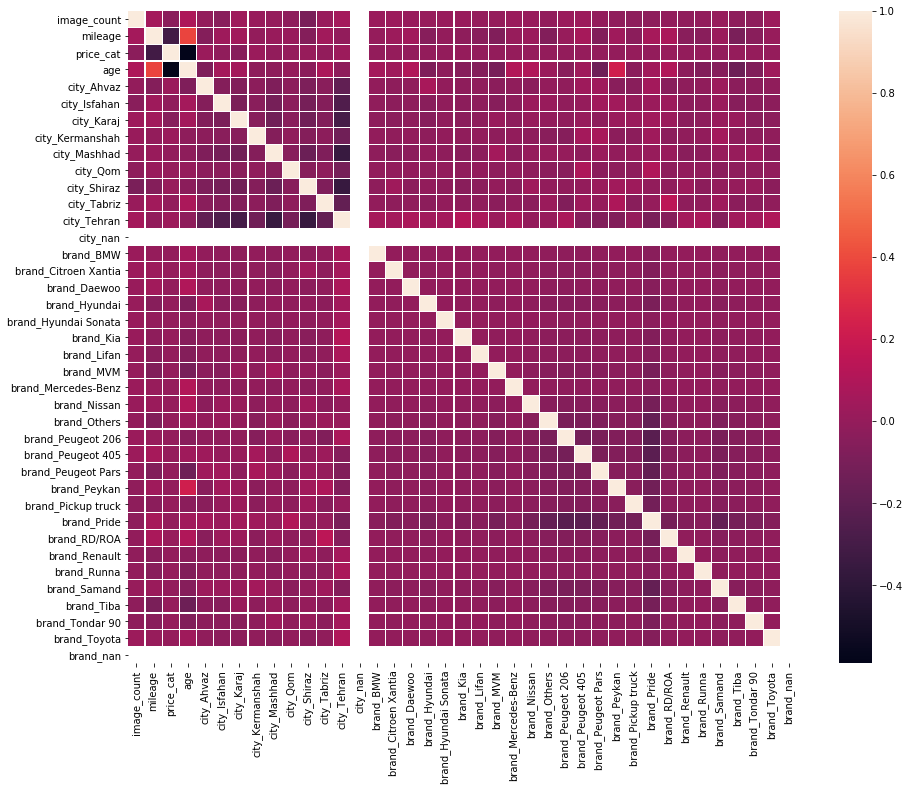

In [3]:
corr = cars.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, ax=ax, linewidths=0.1)

# Train Test Split
split dataset into 4:1

In [10]:
from sklearn.model_selection import train_test_split
X = cars.drop(columns=['price_cat'])
Y = cars['price_cat']
X_test, X_train, Y_test, Y_train = train_test_split(X, Y, test_size=0.2)

### Feature Selection
by this workaround accuracy will drop significantly<br>
convert following block from Markdown to Code, for evaluation

from sklearn.feature_selection import SelectPercentile, SelectKBest, chi2
percentile_best = 10
k_best = 5
#X_new = SelectPercentile(chi2, percentile=percentile_best).fit_transform(X, Y)
X_new = SelectKBest(chi2, k=k_best).fit_transform(X, Y)
print(X_new.shape)

X_test, X_train, Y_test, Y_train = train_test_split(X_new, Y, test_size=0.2)

### Single Brand
by this feature and data reduction, we will focus on a single brand, pride (which is the most used brand)<br>
because of great feature reduction we can user much lower depth for the model (I used depth of 1 and the result was around 83 for both, train and test)

In [14]:
prides = cars.loc[cars['brand_Pride'] == 1][cars.columns.drop(list(cars.filter(regex='brand_')))]

from sklearn.model_selection import train_test_split
X = prides.drop(columns=['price_cat'])
Y = prides['price_cat']
X_test, X_train, Y_test, Y_train = train_test_split(X, Y, test_size=0.2)

# XGBoost

In [15]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, Y_train)
dtest  = xgb.DMatrix(X_test , Y_test )

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 100
bst = xgb.train({
    'learning_rate': .1,
    'min_split_loss': .1,
    'max_depth': 1,
    'nthread': 4
}, dtrain, num_round, evallist)

[0]	eval-rmse:0.89855	train-rmse:0.89962
[1]	eval-rmse:0.83943	train-rmse:0.84032
[2]	eval-rmse:0.78615	train-rmse:0.78693
[3]	eval-rmse:0.73931	train-rmse:0.74034
[4]	eval-rmse:0.69837	train-rmse:0.69899
[5]	eval-rmse:0.66180	train-rmse:0.66226
[6]	eval-rmse:0.62979	train-rmse:0.63015
[7]	eval-rmse:0.60123	train-rmse:0.60152
[8]	eval-rmse:0.57608	train-rmse:0.57605
[9]	eval-rmse:0.55407	train-rmse:0.55399
[10]	eval-rmse:0.53480	train-rmse:0.53446
[11]	eval-rmse:0.51805	train-rmse:0.51767
[12]	eval-rmse:0.50346	train-rmse:0.50287
[13]	eval-rmse:0.49087	train-rmse:0.49023
[14]	eval-rmse:0.47995	train-rmse:0.47913
[15]	eval-rmse:0.47053	train-rmse:0.46965
[16]	eval-rmse:0.46217	train-rmse:0.46109
[17]	eval-rmse:0.45496	train-rmse:0.45385
[18]	eval-rmse:0.44867	train-rmse:0.44741
[19]	eval-rmse:0.44327	train-rmse:0.44199
[20]	eval-rmse:0.43856	train-rmse:0.43717
[21]	eval-rmse:0.43438	train-rmse:0.43299
[22]	eval-rmse:0.43070	train-rmse:0.42932
[23]	eval-rmse:0.42764	train-rmse:0.42617
[2

In [16]:
Y_train_pred = bst.predict(dtrain)
Y_train_pred = list(map(lambda y: int(round(y)), Y_train_pred))

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(Y_train, Y_train_pred)
print('The accuracy of "XGBoost" model for TRAIN on price (categorized into {} classes) is "{:.2f}%"'.format(len(Y_train.unique()), acc_score*100))

The accuracy of "XGBoost" model for TRAIN on price (categorized into 3 classes) is "82.95%"


In [17]:
Y_test_pred = bst.predict(dtest)
Y_test_pred = list(map(lambda y: int(round(y)), Y_test_pred))

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(Y_test, Y_test_pred)
print('The accuracy of "XGBoost" model for TEST on price (categorized into {} classes) is "{:.2f}%"'.format(len(Y_test.unique()), acc_score*100))

The accuracy of "XGBoost" model for TEST on price (categorized into 3 classes) is "82.73%"


### Precision Recall

In [18]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_test_pred, target_names=['1', '2', '3']))

              precision    recall  f1-score   support

           1       0.92      0.81      0.86      8112
           2       0.74      0.78      0.76      7942
           3       0.84      0.89      0.86      8335

    accuracy                           0.83     24389
   macro avg       0.83      0.83      0.83     24389
weighted avg       0.83      0.83      0.83     24389

